In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from textblob import TextBlob

In [5]:
polarity = []

for sentence in df["Review_Text"]:
    polarity.append(TextBlob(sentence).polarity)

In [6]:
subjectivity = []

for sentence in df["Review_Text"]:
    subjectivity.append(TextBlob(sentence).subjectivity)

In [7]:
df["textblob_polarity"], df["textblob_subjectivity"] = polarity, subjectivity

<AxesSubplot:ylabel='Frequency'>

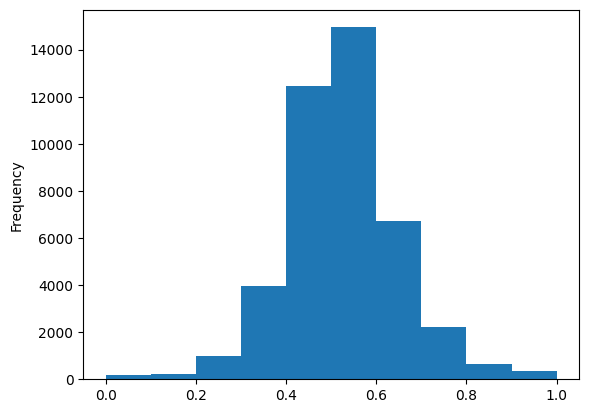

In [8]:
df["textblob_subjectivity"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

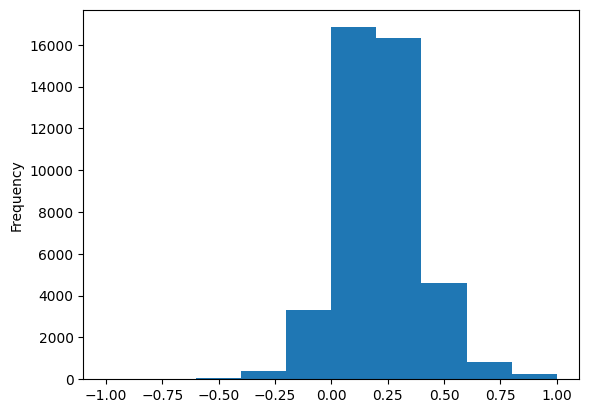

In [9]:
df["textblob_polarity"].plot.hist()

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

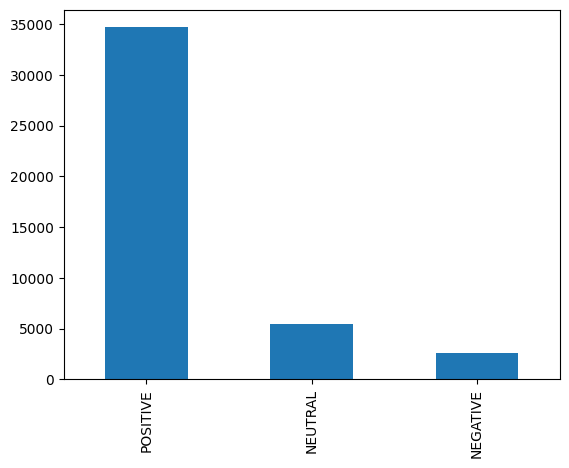

In [13]:
vs = []

for sentence in df["Review_Text"]:
    vs.append(analyzer.polarity_scores(sentence))

df["vs_score"] = vs
df['compound'] = df['vs_score'].apply(lambda score_dict: score_dict['compound'])

# Define custom thresholds
positive_threshold = 0.5
negative_threshold = -0.5

# Assign sentiment types based on custom thresholds
df['vs_sentiment_type'] = ''
df.loc[df.compound > positive_threshold, 'vs_sentiment_type'] = 'POSITIVE'
df.loc[(df.compound >= negative_threshold) & (df.compound <= positive_threshold), 'vs_sentiment_type'] = 'NEUTRAL'
df.loc[df.compound < negative_threshold, 'vs_sentiment_type'] = 'NEGATIVE'

df['vs_sentiment_type'].value_counts().plot.bar()
plt.show()


In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [15]:
# Load the dataset and drop rows with missing ratings
reviews = pd.read_csv("DisneylandReviews.csv", encoding='latin1')
reviews = reviews.dropna(subset=['Rating'])

In [16]:
# Function to classify reviews based on rating
def classify_review(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

In [17]:
reviews['Actual_Sentiment'] = reviews['Rating'].apply(classify_review)

In [18]:
# Apply VADER sentiment analysis
analyzer = SentimentIntensityAnalyzer()

# Obtain compound scores
reviews['compound'] = reviews['Review_Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [24]:
# Obtain TextBlob polarity scores
reviews['textblob_polarity'] = reviews['Review_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [25]:
# Create a new DataFrame with actual sentiment, VADER compound score, and TextBlob polarity score
data = reviews[['Actual_Sentiment', 'compound', 'textblob_polarity']]

In [26]:
# Split the data into training and testing sets
X = data[['compound', 'textblob_polarity']]
y = data['Actual_Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [28]:
# Evaluate the model on the testing set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.46      0.36      0.40       720
     Neutral       0.00      0.00      0.00      1035
    Positive       0.83      0.98      0.90      6777

    accuracy                           0.81      8532
   macro avg       0.43      0.45      0.43      8532
weighted avg       0.70      0.81      0.75      8532



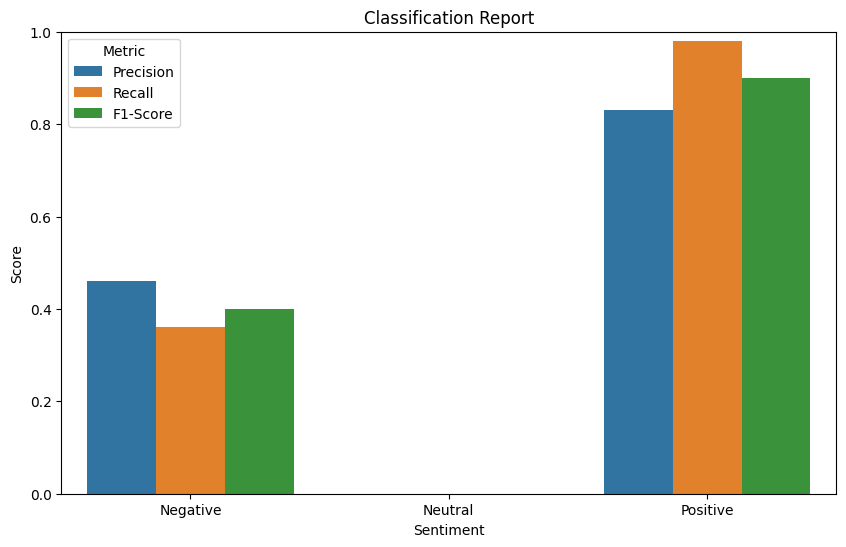

In [30]:
# Create a DataFrame with the classification report's output
report_data = [
    {'Sentiment': 'Negative', 'Precision': 0.46, 'Recall': 0.36, 'F1-Score': 0.40},
    {'Sentiment': 'Neutral', 'Precision': 0.00, 'Recall': 0.00, 'F1-Score': 0.00},
    {'Sentiment': 'Positive', 'Precision': 0.83, 'Recall': 0.98, 'F1-Score': 0.90}
]

report_df = pd.DataFrame(report_data)

# Melt the DataFrame to create a long-form DataFrame suitable for plotting
melted_report_df = report_df.melt(id_vars='Sentiment', var_name='Metric', value_name='Score')

# Create a bar plot for precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='Score', hue='Metric', data=melted_report_df)
plt.title('Classification Report')
plt.ylim(0, 1)
plt.show()